In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from src import image_metrics, io_utils, image_utils
from src.Tile import Tile

# Filtering by symmetry

In this notebook I check that images are symmetric diagonally in any directions for whole image and it's middle part. I ask for at least one 2 of symmetry measures (structural similarity and normalised MSE) to be more than threshold.

I defined metrics to be from 0 to 1, with 1 being more symmetric.

To be fair to all images, before checking their symmetry I crop them, resize them to the same size, and increase their contrast in all colour channels using functions defined in `src.image_utils`.

I tried checking image's horizontal and vertical symmetry in addition to diagonal, but didn't like aesthetically the resulting images with strong horizontal or vertical symmetry.

Diagonal symmetry on it's own also wasn't enough, as images with symmetrical "borders" and assymetrical "centres" were exceeding the threshold, so I started checking middle part of the image separately.

I played with cut-offs until I obtained a sample that consisted of high percentage of good-quality tile images, meaning it is 1 single diagonally symmetric tile that takes up the entire image. This selection ended up very strict, but losing some good quality images in order to obtain sample with 100% goodness rate is a sacrifice I am willing to make.

In [4]:
folder_list = [
    'dataset/google/azulejo',
    'dataset/google/portuguese tiles',
    'dataset/bing/azulejo',
    'dataset/bing/portuguese tile',
    'dataset/bing/azulejo vector',
    'dataset/bing/portuguese tile vector'
]

In [5]:
from skimage.metrics import structural_similarity as ssim, normalized_root_mse

def similarity_mse_based(x, y): return 1 - normalized_root_mse(x, y)
def similarity_ssim_based(x, y): return ssim(x, y, multichannel=True)

metrics = [similarity_mse_based, similarity_ssim_based]

Working on dataset/google/azulejo folder.
Symmetries of the images


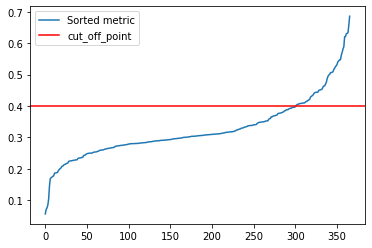

Symmetries of the images' center parts


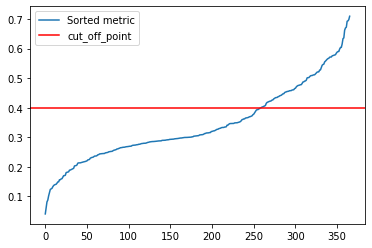

Random sample of not symmetric files:


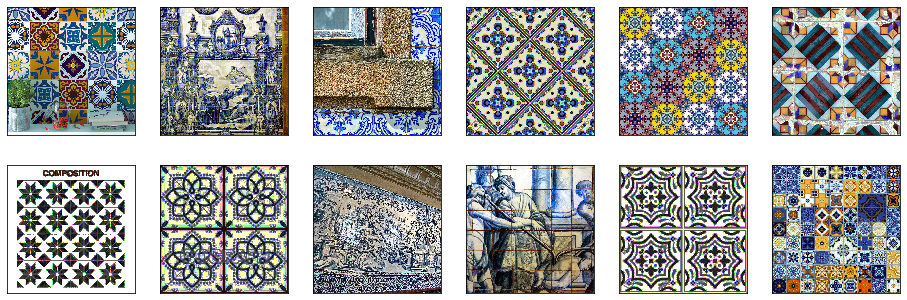

Random sample of symmetric files:


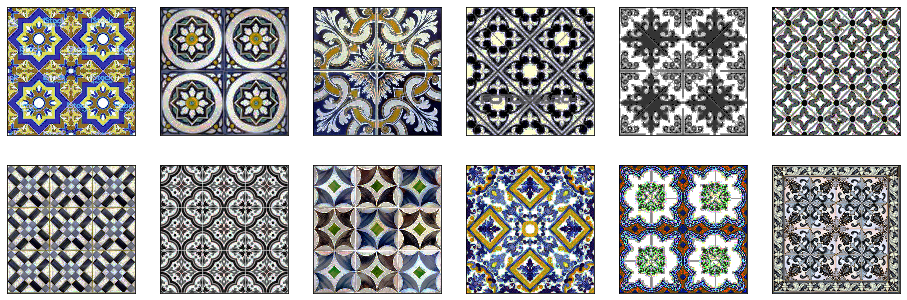

Total files: 366, out of them symmetric: 51.



Working on dataset/google/portuguese tiles folder.
Symmetries of the images


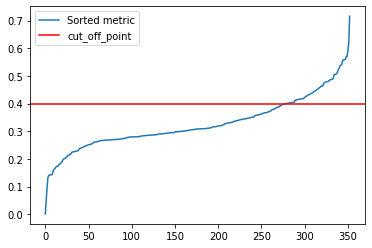

Symmetries of the images' center parts


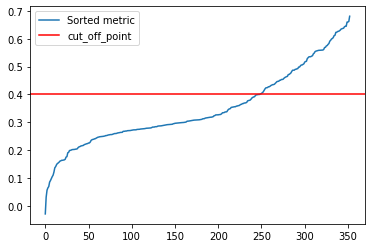

Random sample of not symmetric files:


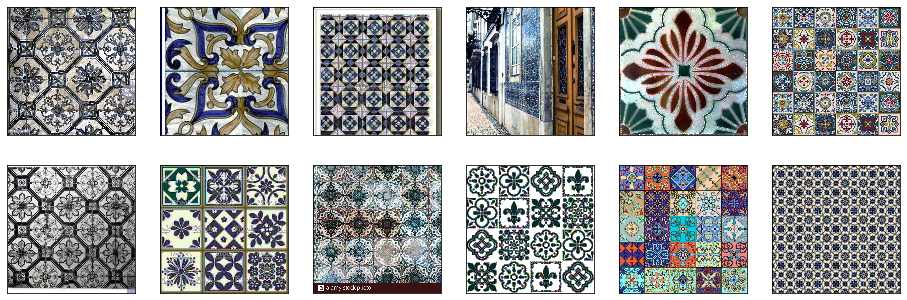

Random sample of symmetric files:


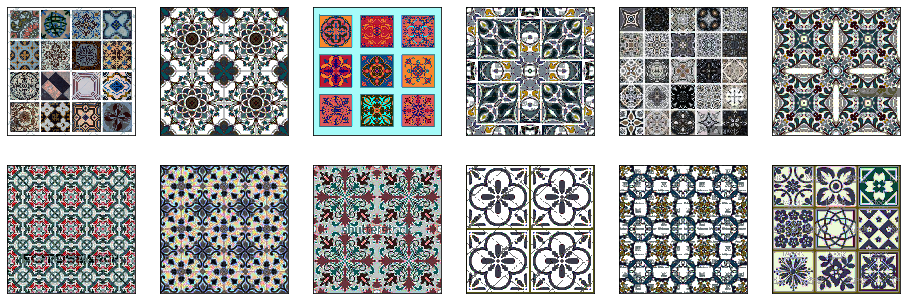

Total files: 353, out of them symmetric: 57.



Working on dataset/bing/azulejo folder.
Symmetries of the images


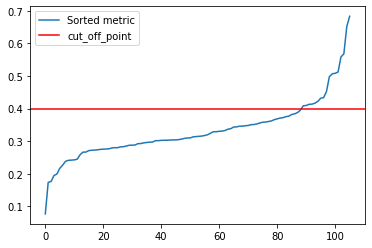

Symmetries of the images' center parts


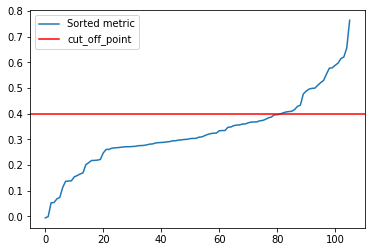

Random sample of not symmetric files:


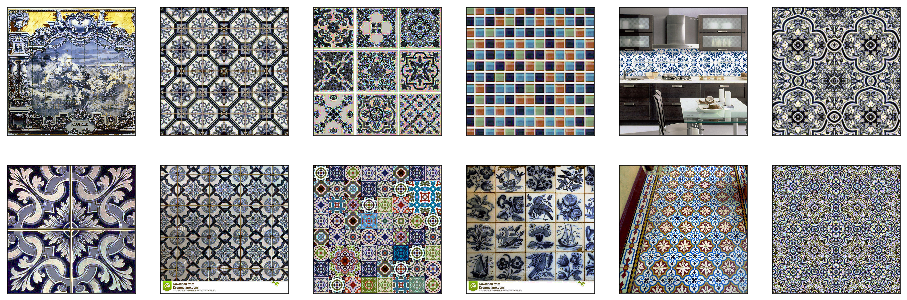

Random sample of symmetric files:


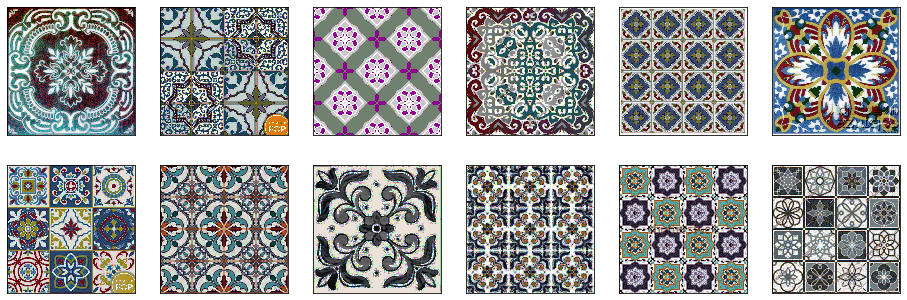

Total files: 106, out of them symmetric: 13.



Working on dataset/bing/portuguese tile folder.
Symmetries of the images


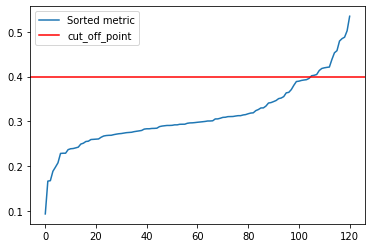

Symmetries of the images' center parts


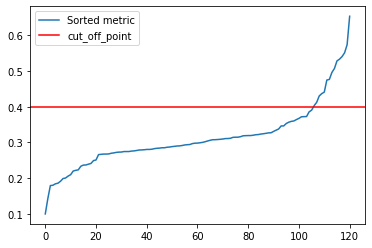

Random sample of not symmetric files:


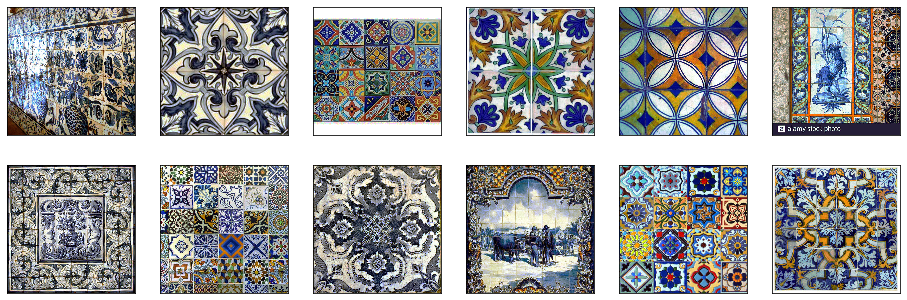

Random sample of symmetric files:


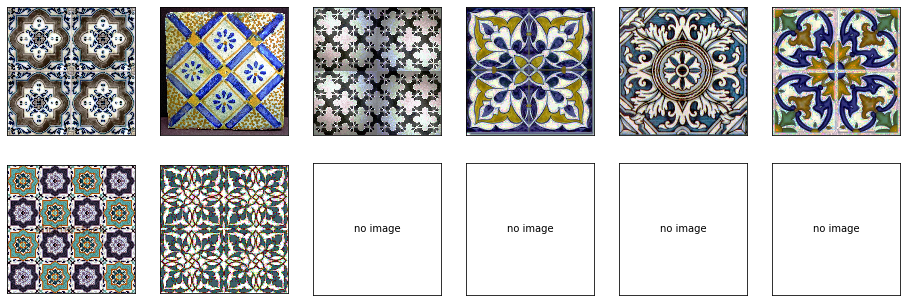

Total files: 121, out of them symmetric: 8.



Working on dataset/bing/azulejo vector folder.
Symmetries of the images


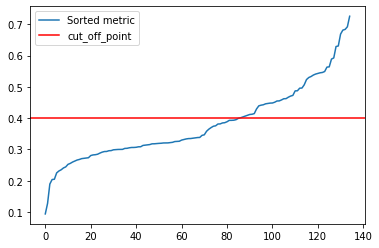

Symmetries of the images' center parts


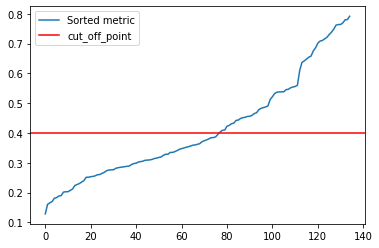

Random sample of not symmetric files:


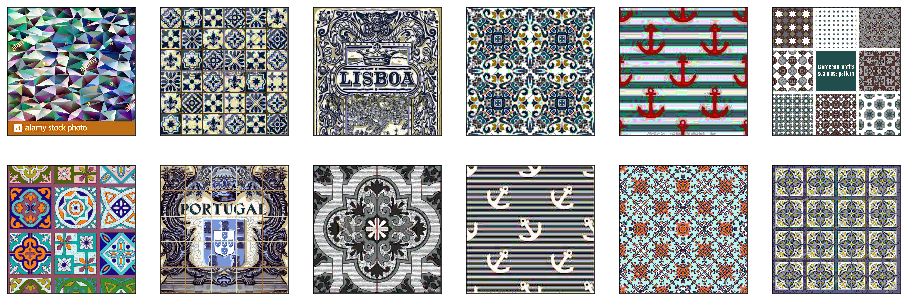

Random sample of symmetric files:


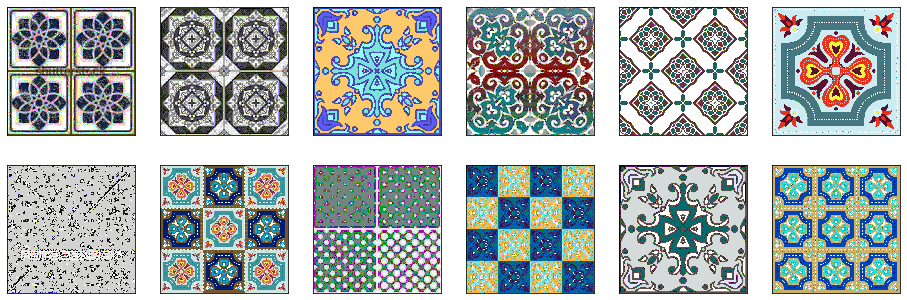

Total files: 135, out of them symmetric: 38.



Working on dataset/bing/portuguese tile vector folder.
Symmetries of the images


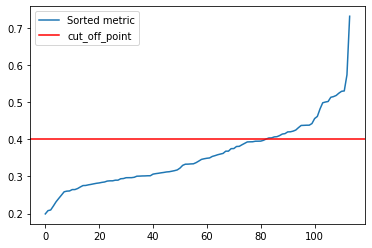

Symmetries of the images' center parts


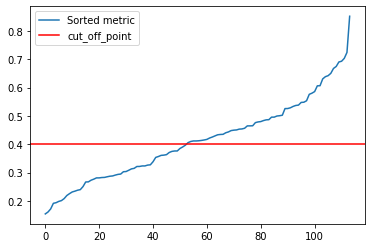

Random sample of not symmetric files:


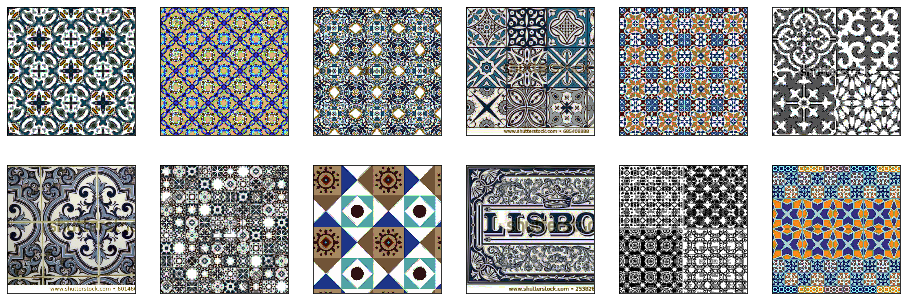

Random sample of symmetric files:


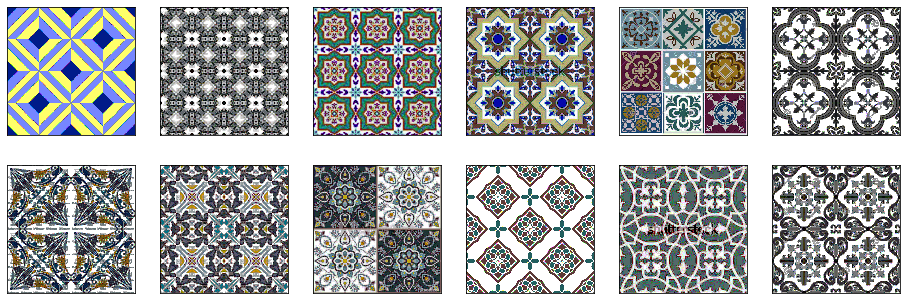

Total files: 114, out of them symmetric: 30.





In [7]:
plot_sample = 12
cut_off = 0.4

def prepare(img): return image_utils.prepare(
    img, 
    resize=True, new_size=(128, 128), 
    apply_contrast=True
)

for folder in folder_list:
    print('Working on {} folder.'.format(folder))
    files = [_.strip() for _ in open('lists/contrasting_{}.txt'.format(folder.replace('/', '-')), 'r').readlines()]
    
    imgs = [
        img 
        for img 
        in io_utils.read_imgs(files, folder)
    ]
    tiles = [Tile(prepare(img)) for img in imgs]
    
    imgs_center = [
        Tile(image_utils.crop(img)).get_square_from_center(0.33).img 
        for img 
        in io_utils.read_imgs(files, folder)
    ]
    tiles_center = [Tile(prepare(img)) for img in imgs_center]
    
    symmetries = [
        max([
            image_metrics.tile_symmetry(tile, metric, min)
            for metric 
            in metrics
        ]) 
        for tile 
        in tiles
    ]
    symmetries_center = [
        max([
            image_metrics.tile_symmetry(tile, metric, min) 
            for metric 
            in metrics
        ])
        for tile 
        in tiles_center
    ]

    
    print('Symmetries of the images')
    io_utils.plot_metric(symmetries, cut_off)
    
    print('Symmetries of the images\' center parts')
    io_utils.plot_metric(symmetries_center, cut_off)
    
    files_symmetric = [
        file
        for (file, symmetry, symmetry_center)
        in zip(files, symmetries, symmetries_center) 
        if (symmetry >= cut_off) and (symmetry_center >= cut_off)
    ]
    imgs_symmetric = [prepare(img) for img in io_utils.read_imgs(files_symmetric, folder)]
    
    files_other = [_ for _ in files if _ not in files_symmetric]
    imgs_other = [prepare(img) for img in io_utils.read_imgs(files_other, folder)]
    
    print('Random sample of not symmetric files:')
    io_utils.plot_sample_imgs(imgs_other, plot_sample=plot_sample)
    
    print('Random sample of symmetric files:')
    io_utils.plot_sample_imgs(imgs_symmetric, plot_sample=plot_sample)
    
    print('Total files: {}, out of them symmetric: {}.'.format(len(files), len(files_symmetric)))
    
    with open('lists/symmetric_{}.txt'.format(folder.replace('/', '-')), 'w') as filehandle:
        for filename in files_symmetric:
            filehandle.write('%s\n' % filename)
            
    print('\n\n')